## EfficientNetB5 with Squeeze and Excitation + Attention Selective Fusion + DINOv2

In this notebook, our team evaluates the performance of EfficientNetB5 on our dataset, served as the baseline evaluation.

**This notebook contains the following sections:**
1. Loading Preprocessed Dataset
2. EfficientNetB5 with Squeeze and Excitation, Attention Selective Fusion and DINOv2 Model architecture   
3. Hyperparameter Tuning  
4. Model Training
5. Model Evaluation

**Assumed project structure:**
```markdown
ROOT
├── notebooks
│   └── EfficientNetDINOv2.ipynb
└── input
    └── final_split_15Apr2025
        ├── train
        ├── eval
        └── test
```
* if dataset not downloaded, dataset would download in the loading dataset section.

References: 
- https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/
- https://discuss.pytorch.org/t/partial-transfer-learning-efficientnet/109689 
- https://docs.ray.io/en/latest/tune/examples/includes/async_hyperband_example.html
- https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html 
- https://docs.ray.io/en/latest/tune/examples/includes/mnist_pytorch.html
- https://docs.ray.io/en/latest/tune/api/suggestion.html

Configurable Variables:
- **root (str)**: Root directory of the project (commonly set to '..').
- **data_set_directory (str)**: Name of the directory containing all datasets (i.e.,'input')
- **final_data_set (str)**: Folder name of the final processed and augmented dataset used for training.
- **root_result_folder (str)**: Top-level directory name for storing evaluation results.
- **model_directory (str)**: Directory name where all trained models will be saved.
- **model_name (str)**: Abbreviation or identifier for the model being trained (used for file naming).
- **batch_size (int)**: Number of samples per training/validation batch.

In [1]:
# Control Panel to adjust variables
root = ".."
data_set_directory = "input"
final_data_set = "final_split_15Apr2025"
root_result_folder = "results"
model_directory = "models" 
google_drive_id = "1XhSO100qgRuLEyopfb7-4gBp0CRjZkfg"

model_name = "FINAL_EfficientNetDINOv2" # Name of the model that the file is training in abbreviation
batch_size = 8 # State the number of datapoints in each batch size

In [2]:
from typing import List, Optional, Callable
import os
import sys
from tqdm.auto import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

# Determine the project root - required to import DataHandler from utils folder
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), root))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from utils.DataHandler import download_dataset, create_full_data_loaders, create_tuning_data_loaders

## Loading Dataset and File Location Variables

Global Variables Created:
- **PROJECT_ROOT (str)**: Absolute path to the project’s root directory; added to `sys.path` for imports.
- **LOG_DIR (str)**: Path to the directory where log files will be written.
- **MODEL_SAVE_DIR (str)**: Directory for saving model checkpoints and final trained model files.
- **CHECKPOINT_DIR (str)**: Directory where intermediate checkpoints for hyperparameter tuning are stored.
- **RESULTS_DIR (str)**: Path to store evaluation results and metrics, separated by model name.
- **BEST_MODEL_PATH (str)**: Full path to the file where the best-performing model will be saved.
- **DATASET_FOLDER (str)**: Full path to the folder containing the dataset used for training.
- **DEVICE (torch.device)**: The hardware device selected for training ('cuda', 'mps', or 'cpu').


In [3]:
# Configuring log file
LOG_DIR = os.path.join(PROJECT_ROOT, "logs")
os.makedirs(LOG_DIR, exist_ok=True)
log_filename = os.path.join(LOG_DIR, F"{model_name}_training_log.txt")
logging.basicConfig(
    filename=log_filename,
    filemode="w",  #NOTE: previous logs would be overwritten
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO
)

# Creating the models save location
MODEL_SAVE_DIR = os.path.join(PROJECT_ROOT, model_directory, model_name)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, F"{model_directory}/hyptune/{model_name}")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

RESULTS_DIR = os.path.join(PROJECT_ROOT, F"{root_result_folder}/{model_name}")
print(RESULTS_DIR)
os.makedirs(RESULTS_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, F"{model_name}_best_model.pt")

DATASET_FOLDER = os.path.join(root, data_set_directory,final_data_set)

# Gets the device to be used
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

DEVICE = get_device()

c:\Users\Ning\DogEmotionADL\results/FINAL_EfficientNetDINOv2
Using device: CUDA (GPU)


### Download Dataset

In [4]:
# Function to download the processed dataset used by the team
download_dataset(final_data_set,f"https://drive.google.com/uc?id={google_drive_id}",  F"{DATASET_FOLDER}.zip", "../input")

Dataset already exists at final_split_15Apr2025


### Loading Dataset

In [5]:
SPLIT_DATASET = os.path.abspath(DATASET_FOLDER)

# Define data transformation 
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

print("LOADING SUBSET DATASET-----------------------------------------------------")
TRAIN_LOADER, VAL_LOADER, TEST_LOADER = create_tuning_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=batch_size,
    subset_fraction=0.5,
    random_seed=42
)
print("LOADING FULL DATASET-------------------------------------------------------")
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=batch_size,
)

LOADING SUBSET DATASET-----------------------------------------------------
Using pre-split datasets: train 8025, val 579, test 572
Created tuning data loaders with subset fraction: 0.5
Created subset datasets for hyperparameter tuning: train 4012, val 289, test 572
Class Distribution for Subset Training:
  angry     : 983
  happy     : 1039
  relaxed   : 1024
  sad       : 966
Class Distribution for Subset Validation:
  angry     : 71
  happy     : 75
  relaxed   : 74
  sad       : 69
LOADING FULL DATASET-------------------------------------------------------
Using pre-split datasets: train 8025, val 579, test 572


## Model Specification

This part of the file will change largely based on each of the models that are being created

In [ ]:
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class AttentionalSelectiveFusion(nn.Module):
    """Simple channel‑attention fusion block"""
    def __init__(self, in_channels: int):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels // 16, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 16, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(self.avg(x))
        return x * w
       
class EfficientNetDINOv2(nn.Module):
    """Modified EfficientNetB5 with Squeeze and Extraction Blocks for feature extraction;
    then DINOv2 model on the dog emotion dataset
    with a configurable classification head for hyperparameter tuning, 
    i.e parameters you wish to tune need to be specified
    """
    
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 freeze_backbone: bool = False,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu') -> None:
        """
        Args:
            num_classes (int): Number of output classes.
            dropout (float): Dropout rate to apply in the classifier.
            freeze_backbone (bool): If True, freeze the backbone layers.
            hidden_sizes (Optional[List[int]]): List of sizes for hidden layers in the classifier.
                If None, a single linear layer is used.
            activation (str): Activation function to use in the classifier ('relu', 'tanh', etc.).
        """
        super(EfficientNetDINOv2, self).__init__()


        # load EfficientNet‑B5 backbone
        self.backbone = efficientnet_b5(weights=EfficientNet_B5_Weights.DEFAULT).features  # [B, 2048, 15, 15] for 456x456 image

        # freeze backbone
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            for name, param in self.backbone.named_parameters():
                if "6" in name or "7" in name:
                    param.requires_grad = True

        # SE block
        self.se = SqueezeExcitationBlock(2048)

        # Attentional Selective Fusion & projection to match DINOv2 model
        self.asf   = AttentionalSelectiveFusion(2048)
        self.proj  = nn.Conv2d(2048, 384, kernel_size=1)

        # force map to 37×37 so token count matches DINOv2‑ViT‑S/14 (1370 = 1+37²)
        self.adapt = nn.AdaptiveAvgPool2d((37, 37))

        # DINOv2 (ViT‑S/14) without patch embed
        self.dino  = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
        # freeze too
        if freeze_backbone:
            for param in self.dino.parameters():
                param.requires_grad = False
            for param in self.dino.blocks[-1].parameters():
                param.requires_grad = True
            for param in self.dino.norm.parameters():
                param.requires_grad = True

        # build classifier
        layers = []
        input_dim = self.dino.embed_dim  #should be 384
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
            # final classification layer
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        else:
            # single linear layer if no hidden layers specified
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        
        self.classifier = nn.Sequential(*layers)

    def _get_activation(self, activation: str) -> Callable:
        """Returns an activation function based on the given string.

        Args:
            activation (str): Name of the activation function.

        Returns:
            Callable: Activation function module.
        """
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'leakyrelu':
            return nn.LeakyReLU()
        elif activation.lower() == 'gelu':
            return nn.GELU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # EfficientNet feature map
        x = self.backbone(x)          # [B, 2048, 7, 7]
        x = self.se(x)
        x = self.asf(x)               # attentional fusion
        x = self.proj(x)              # [B, 384, 7, 7]
        x = self.adapt(x)             # [B, 384, 37, 37]

        # transformer expects image to the patch embedding layer, need to bypass
        # prepare tokens for DINOv2 transformer
        B, C, H, W = x.shape
        tokens = x.flatten(2).transpose(1, 2)   # [B, 1369, 384]

        # prepend cls token + add positional embedding
        cls_tok  = self.dino.cls_token.expand(B, -1, -1)  # [B,1,384]
        tokens   = torch.cat((cls_tok, tokens), dim=1)     # [B,1370,384]
        tokens   = tokens + self.dino.pos_embed            # match length 1370

        # transformer encoder
        for blk in self.dino.blocks:
            tokens = blk(tokens)
        tokens = self.dino.norm(tokens)

        # take CLS representation
        rep = tokens[:, 0]            # [B, 384]
        return self.classifier(rep)

In [9]:
print(f"Using device: {DEVICE}")
model = EfficientNetDINOv2(num_classes=4, dropout=0.3, freeze_backbone=True, hidden_sizes=[256, 128], activation='relu').to(DEVICE)
print("Model instantiated:", model.__class__.__name__)
print(model)

Using device: cuda


Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model instantiated: EfficientNetDINOv2
EfficientNetDINOv2(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmo

## Hyperparameter Tuning
This is the part where you write the training function and load it to the ray tune scheduler.
For this execution, ASHAscheduler is used with Optuna for bayesian optimisation techniques - which should be using the default Tree-Structured Parzen Estimator.
If many parameters, this is would be more efficient than grid search and random search.

The hyperparameters in deep learning to tune are 
- the number of neurons
- activation function
- optimiser
- learning rate
- batch size
- epochs 
- number of layers.

In [10]:
def train_model( config, device=DEVICE, checkpoint_dir=CHECKPOINT_DIR, data_dir=None):
    """Training function for Ray Tune hyperparameter tuning.

    This function instantiates the model with hyperparameters
    specified in the config dictionary, trains the model on the global TRAIN_LOADER,
    evaluates on VAL_LOADER, and reports the validation loss to Ray Tune.

    Args:
        config (dict): Hyperparameter configuration. Expected keys include:
            - lr (float): Learning rate.
            - weight_decay (float): Weight decay for the optimizer.
            - dropout (float): Dropout rate for the classifier.
            - hidden_sizes (list or None): List of hidden layer sizes in the classifier.
            - activation (str): Activation function to use ('relu', 'tanh', etc.).
            - freeze_backbone (bool): Whether to freeze the model backbone.
            - num_epochs (int): Number of training epochs.
            - optimiser (callable, optional): Optimiser class. Default is optim.Adam.
            - criterion (callable, optional): Loss function instance. Default is nn.CrossEntropyLoss().
        checkpoint_dir (str, optional): Directory for checkpointing (if applicable).
        data_dir (str, optional): Not used here; included for compatibility.
    """
    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
        
    # instantiate model with hyperparameters from config
    model = EfficientNetDINOv2(
        num_classes=4,
        dropout=config.get("dropout", 0.3),
        freeze_backbone=config.get("freeze_backbone", True),
        hidden_sizes=config.get("hidden_sizes", None),
        activation=config.get("activation", "relu")
    ).to(device)

    optimiser = config["optimiser"](model.parameters(), config["lr"], config["weight_decay"])
    criterion = config["criterion"](config["label_smooth"])

    num_epochs = config.get("num_epochs", 2)  # a low number for quick tuning, but update accordingly
        
    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0
        for inputs, targets in tqdm(TRAIN_LOADER, position=0, leave=True, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * inputs.size(0)
            running_correct += (outputs.argmax(1) == targets).sum().item()
            running_total   += targets.size(0) 
            
        epoch_loss = running_loss / running_total
        epoch_acc  = running_correct / running_total
        print(f"[TRAIN] epoch {epoch+1}: loss={epoch_loss:.4f} acc={epoch_acc:.3f}")
            
        # optionally, can checkpoint the model
        if checkpoint_dir:
            path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
            torch.save(model.state_dict(), path)
        
    # evaluation on the subset validation set
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == targets).sum().item()
            val_total   += targets.size(0)
        
    avg_val_loss = val_loss / val_total
    avg_val_acc  = val_correct / val_total
    print(f"[VAL] loss={avg_val_loss:.4f} acc={avg_val_acc:.3f}")
        
    # Report the metric to Ray Tune
    tune.report({"loss": avg_val_loss, "acc": avg_val_acc})

In [11]:
asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='loss',
    mode='min',
    max_t=100,
    grace_period=2,    
    reduction_factor=2,
    brackets=1,
)

optuna_search = OptunaSearch(metric="loss", mode="min", seed=42)

# define search space in a config dictionary, i.e what are the values you want to try
config = {
    "lr": tune.loguniform(1e-5, 1e-3),    
    "weight_decay": tune.loguniform(1e-5, 1e-3),
    "dropout": tune.uniform(0.3, 0.5),
    "hidden_sizes": None,
    "activation": tune.choice(["relu", "leakyrelu", "gelu"]),
    "freeze_backbone": True,
    "label_smooth": tune.choice([0.0, 0.05, 0.1]),
    "num_epochs": 10,
    "optimiser": tune.choice([
        lambda params, lr, wd: optim.AdamW(params, lr=lr, weight_decay=wd),
        lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
        # lambda params, lr, wd: optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    ]),
    "criterion": tune.choice([
        lambda ls: nn.CrossEntropyLoss(label_smoothing=ls),
    ])
}

def trial_dirname_creator(trial):
    # this is meant to create short and unique directory name for each trial bc else too long for windows
    # include a unique identifier (like trial.trial_id).
    return f"trial_{trial.trial_id}"

def trial_name_creator(trial):
    return f"t_{trial.trial_id}"

# tuner object
tuner = tune.Tuner(
    tune.with_resources(train_model, {"cpu": 10, "gpu": 1}), #NOTE: specify based on the device u using because by default it uses all, i.e if u have 4 cpus; it does 4 concurrent trials
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
        search_alg=optuna_search,
        num_samples=15,  # number of trials to run
        trial_dirname_creator=trial_dirname_creator,
        trial_name_creator=trial_name_creator, 
    ),
    run_config=tune.RunConfig(
        name="efficientnetb5_dinov2_final",
        storage_path="C:/ray_results/efficientnetb5_dinov2_final", #NOTE: not required for mac
        log_to_file=True,
        verbose=1,
        ),
    param_space=config,
)

results = tuner.fit()
print("Best config:", results.get_best_result(metric="loss", mode="min",filter_nan_and_inf=False).config)

best_config = results.get_best_result(metric="loss", mode="min").config
print("Full best config:", best_config)

(train_model pid=28836) Checkpoint Folder exists


(train_model pid=28836) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=28836) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=28836)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=28836) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=28836)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=28836) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=28836)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 502/502 [03:28<00:00,  2.41it/s]


(train_model pid=28836) [TRAIN] epoch 1: loss=1.1139 acc=0.548


Epoch 3/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=28836) [TRAIN] epoch 2: loss=0.5450 acc=0.855


Epoch 3/10: 100%|██████████| 502/502 [03:24<00:00,  2.46it/s]


(train_model pid=28836) [TRAIN] epoch 3: loss=0.3821 acc=0.926


Epoch 4/10: 100%|██████████| 502/502 [03:24<00:00,  2.46it/s]


(train_model pid=28836) [TRAIN] epoch 4: loss=0.3067 acc=0.963


Epoch 5/10: 100%|█████████▉| 501/502 [03:24<00:00,  2.46it/s]


(train_model pid=28836) [TRAIN] epoch 5: loss=0.2751 acc=0.976


Epoch 6/10: 100%|██████████| 502/502 [03:24<00:00,  2.46it/s]


(train_model pid=28836) [TRAIN] epoch 6: loss=0.2609 acc=0.980


Epoch 7/10: 100%|██████████| 502/502 [03:24<00:00,  2.45it/s]


(train_model pid=28836) [TRAIN] epoch 7: loss=0.2494 acc=0.982


Epoch 8/10: 100%|██████████| 502/502 [03:24<00:00,  2.46it/s]


(train_model pid=28836) [TRAIN] epoch 8: loss=0.2435 acc=0.985


Epoch 9/10: 100%|██████████| 502/502 [03:24<00:00,  2.45it/s]


(train_model pid=28836) [TRAIN] epoch 9: loss=0.2483 acc=0.982


Epoch 10/10: 100%|██████████| 502/502 [03:24<00:00,  2.45it/s]


(train_model pid=28836) [TRAIN] epoch 10: loss=0.2357 acc=0.989


2025-04-21 20:34:20,824	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=28836) [VAL] loss=0.6260 acc=0.837
(train_model pid=12744) Checkpoint Folder exists


(train_model pid=12744) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=12744) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=12744)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=12744) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=12744)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=12744) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=12744)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=12744) [TRAIN] epoch 1: loss=1.2653 acc=0.515


Epoch 2/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=12744) [TRAIN] epoch 2: loss=0.9990 acc=0.584


Epoch 3/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=12744) [TRAIN] epoch 3: loss=0.9989 acc=0.576


Epoch 4/10: 100%|██████████| 502/502 [03:18<00:00,  2.53it/s]


(train_model pid=12744) [TRAIN] epoch 4: loss=1.0329 acc=0.556


Epoch 5/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=12744) [TRAIN] epoch 5: loss=0.8820 acc=0.630


Epoch 6/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=12744) [TRAIN] epoch 6: loss=0.9015 acc=0.634


Epoch 7/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=12744) [TRAIN] epoch 7: loss=0.8633 acc=0.667


Epoch 8/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=12744) [TRAIN] epoch 8: loss=1.0772 acc=0.545


Epoch 10/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=12744) [TRAIN] epoch 9: loss=1.0745 acc=0.511


Epoch 10/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=12744) [TRAIN] epoch 10: loss=1.0386 acc=0.513


2025-04-21 21:07:47,178	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=12744) [VAL] loss=0.9580 acc=0.512
(train_model pid=20184) Checkpoint Folder exists


(train_model pid=20184) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=20184) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=20184)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=20184) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=20184)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=20184) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=20184)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=20184) [TRAIN] epoch 1: loss=1.2340 acc=0.486


Epoch 2/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=20184) [TRAIN] epoch 2: loss=0.7215 acc=0.812


Epoch 3/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=20184) [TRAIN] epoch 3: loss=0.5409 acc=0.913


Epoch 4/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=20184) [TRAIN] epoch 4: loss=0.4645 acc=0.953


Epoch 5/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=20184) [TRAIN] epoch 5: loss=0.4197 acc=0.974


Epoch 7/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=20184) [TRAIN] epoch 6: loss=0.3998 acc=0.983


Epoch 7/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=20184) [TRAIN] epoch 7: loss=0.3862 acc=0.989


Epoch 9/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=20184) [TRAIN] epoch 8: loss=0.3871 acc=0.987


Epoch 9/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=20184) [TRAIN] epoch 9: loss=0.3849 acc=0.986


Epoch 10/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=20184) [TRAIN] epoch 10: loss=0.3834 acc=0.988


2025-04-21 21:41:16,977	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=20184) [VAL] loss=0.8864 acc=0.765
(train_model pid=14220) Checkpoint Folder exists


(train_model pid=14220) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=14220) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=14220)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=14220) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=14220)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=14220) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=14220)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=14220) [TRAIN] epoch 1: loss=1.3661 acc=0.439


Epoch 2/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=14220) [TRAIN] epoch 2: loss=1.0465 acc=0.621


Epoch 3/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=14220) [TRAIN] epoch 3: loss=0.9539 acc=0.683


Epoch 4/10: 100%|██████████| 502/502 [03:18<00:00,  2.52it/s]


(train_model pid=14220) [TRAIN] epoch 4: loss=0.8589 acc=0.734


Epoch 6/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=14220) [TRAIN] epoch 5: loss=0.8078 acc=0.762


Epoch 6/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=14220) [TRAIN] epoch 6: loss=0.7731 acc=0.787


Epoch 7/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=14220) [TRAIN] epoch 7: loss=0.7168 acc=0.813


Epoch 8/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=14220) [TRAIN] epoch 8: loss=0.7244 acc=0.808


Epoch 9/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=14220) [TRAIN] epoch 9: loss=0.6868 acc=0.836


Epoch 10/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=14220) [TRAIN] epoch 10: loss=0.6519 acc=0.853


2025-04-21 22:14:44,507	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=14220) [VAL] loss=0.7950 acc=0.775
(train_model pid=38580) Checkpoint Folder exists


(train_model pid=38580) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=38580) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=38580)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=38580) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=38580)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=38580) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=38580)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 502/502 [03:30<00:00,  2.39it/s]


(train_model pid=38580) [TRAIN] epoch 1: loss=1.0672 acc=0.537


Epoch 2/10: 100%|██████████| 502/502 [03:25<00:00,  2.44it/s]


(train_model pid=38580) [TRAIN] epoch 2: loss=0.4791 acc=0.822


Epoch 4/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=38580) [TRAIN] epoch 3: loss=0.2522 acc=0.910


Epoch 4/10: 100%|██████████| 502/502 [03:24<00:00,  2.46it/s]


(train_model pid=38580) [TRAIN] epoch 4: loss=0.1454 acc=0.949


Epoch 5/10: 100%|██████████| 502/502 [03:24<00:00,  2.45it/s]


(train_model pid=38580) [TRAIN] epoch 5: loss=0.1093 acc=0.963


Epoch 7/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=38580) [TRAIN] epoch 6: loss=0.0778 acc=0.973


Epoch 7/10: 100%|██████████| 502/502 [03:24<00:00,  2.46it/s]


(train_model pid=38580) [TRAIN] epoch 7: loss=0.0653 acc=0.979


Epoch 9/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=38580) [TRAIN] epoch 8: loss=0.0608 acc=0.980


Epoch 10/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=38580) [TRAIN] epoch 9: loss=0.0360 acc=0.988


Epoch 10/10: 100%|██████████| 502/502 [03:24<00:00,  2.46it/s]


(train_model pid=38580) [TRAIN] epoch 10: loss=0.0471 acc=0.985


2025-04-21 22:49:10,367	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=38580) [VAL] loss=0.7776 acc=0.830
(train_model pid=5700) Checkpoint Folder exists


(train_model pid=5700) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=5700) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=5700)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=5700) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=5700)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=5700) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=5700)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=5700) [TRAIN] epoch 1: loss=1.1930 acc=0.547


Epoch 2/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=5700) [TRAIN] epoch 2: loss=0.8287 acc=0.733


Epoch 4/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=5700) [TRAIN] epoch 3: loss=0.8435 acc=0.710


Epoch 4/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=5700) [TRAIN] epoch 4: loss=0.7901 acc=0.749


Epoch 5/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=5700) [TRAIN] epoch 5: loss=0.8014 acc=0.728


Epoch 6/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=5700) [TRAIN] epoch 6: loss=0.8285 acc=0.720


Epoch 7/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=5700) [TRAIN] epoch 7: loss=0.6780 acc=0.793


Epoch 8/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=5700) [TRAIN] epoch 8: loss=0.8288 acc=0.719


Epoch 9/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=5700) [TRAIN] epoch 9: loss=0.7330 acc=0.764


Epoch 10/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=5700) [TRAIN] epoch 10: loss=0.6497 acc=0.800


2025-04-21 23:22:39,408	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=5700) [VAL] loss=0.6902 acc=0.775
(train_model pid=35800) Checkpoint Folder exists


(train_model pid=35800) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=35800) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=35800)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=35800) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=35800)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=35800) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=35800)   warnings.warn("xFormers is not available (Block)")
Epoch 2/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=35800) [TRAIN] epoch 1: loss=1.2375 acc=0.447


Epoch 3/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=35800) [TRAIN] epoch 2: loss=0.7264 acc=0.759


Epoch 3/10: 100%|█████████▉| 500/502 [03:19<00:00,  2.51it/s]


(train_model pid=35800) [TRAIN] epoch 3: loss=0.5063 acc=0.870


Epoch 4/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=35800) [TRAIN] epoch 4: loss=0.4189 acc=0.907


Epoch 5/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=35800) [TRAIN] epoch 5: loss=0.3610 acc=0.941


Epoch 6/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=35800) [TRAIN] epoch 6: loss=0.3099 acc=0.961


Epoch 7/10: 100%|█████████▉| 501/502 [03:19<00:00,  2.51it/s]


(train_model pid=35800) [TRAIN] epoch 7: loss=0.2805 acc=0.975


Epoch 8/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=35800) [TRAIN] epoch 8: loss=0.2742 acc=0.975


Epoch 9/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=35800) [TRAIN] epoch 9: loss=0.2636 acc=0.977


Epoch 10/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=35800) [TRAIN] epoch 10: loss=0.2507 acc=0.983


2025-04-21 23:56:09,718	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=35800) [VAL] loss=0.8645 acc=0.792
(train_model pid=29748) Checkpoint Folder exists


(train_model pid=29748) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=29748) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=29748)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=29748) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=29748)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=29748) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=29748)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 502/502 [03:20<00:00,  2.51it/s]


(train_model pid=29748) [TRAIN] epoch 1: loss=1.3141 acc=0.396


Epoch 2/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=29748) [TRAIN] epoch 2: loss=0.9086 acc=0.674


Epoch 3/10: 100%|█████████▉| 501/502 [03:19<00:00,  2.52it/s]


(train_model pid=29748) [TRAIN] epoch 3: loss=0.7512 acc=0.791


Epoch 5/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=29748) [TRAIN] epoch 4: loss=0.6519 acc=0.844


Epoch 5/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=29748) [TRAIN] epoch 5: loss=0.5728 acc=0.892


Epoch 6/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=29748) [TRAIN] epoch 6: loss=0.5171 acc=0.922


Epoch 8/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=29748) [TRAIN] epoch 7: loss=0.4778 acc=0.945


Epoch 8/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=29748) [TRAIN] epoch 8: loss=0.4522 acc=0.962


Epoch 9/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=29748) [TRAIN] epoch 9: loss=0.4316 acc=0.971


Epoch 10/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=29748) [TRAIN] epoch 10: loss=0.4184 acc=0.976


2025-04-22 00:29:41,091	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=29748) [VAL] loss=0.7881 acc=0.824
(train_model pid=20144) Checkpoint Folder exists


(train_model pid=20144) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=20144) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=20144)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=20144) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=20144)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=20144) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=20144)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=20144) [TRAIN] epoch 1: loss=1.4143 acc=0.382


Epoch 2/10: 100%|█████████▉| 500/502 [03:18<00:00,  2.51it/s]


(train_model pid=20144) [TRAIN] epoch 2: loss=0.9877 acc=0.564


Epoch 4/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=20144) [TRAIN] epoch 3: loss=0.9913 acc=0.521


Epoch 4/10: 100%|██████████| 502/502 [03:18<00:00,  2.53it/s]


(train_model pid=20144) [TRAIN] epoch 4: loss=0.7792 acc=0.644


Epoch 5/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=20144) [TRAIN] epoch 5: loss=0.6378 acc=0.737


Epoch 6/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=20144) [TRAIN] epoch 6: loss=0.6784 acc=0.725


Epoch 7/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=20144) [TRAIN] epoch 7: loss=0.4856 acc=0.813


Epoch 9/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=20144) [TRAIN] epoch 8: loss=0.5695 acc=0.785


Epoch 10/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=20144) [TRAIN] epoch 9: loss=0.4858 acc=0.817


Epoch 10/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=20144) [TRAIN] epoch 10: loss=0.4403 acc=0.839


2025-04-22 01:03:07,252	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=20144) [VAL] loss=0.7430 acc=0.744
(train_model pid=39216) Checkpoint Folder exists


(train_model pid=39216) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=39216) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=39216)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=39216) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=39216)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=39216) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=39216)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 502/502 [03:20<00:00,  2.51it/s]


(train_model pid=39216) [TRAIN] epoch 1: loss=1.4074 acc=0.376


Epoch 3/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=39216) [TRAIN] epoch 2: loss=0.8571 acc=0.734


Epoch 4/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=39216) [TRAIN] epoch 3: loss=0.6681 acc=0.854


Epoch 5/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=39216) [TRAIN] epoch 4: loss=0.5738 acc=0.896


Epoch 6/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=39216) [TRAIN] epoch 5: loss=0.5121 acc=0.928


Epoch 7/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=39216) [TRAIN] epoch 6: loss=0.4690 acc=0.955


Epoch 7/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=39216) [TRAIN] epoch 7: loss=0.4573 acc=0.958


Epoch 8/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=39216) [TRAIN] epoch 8: loss=0.4244 acc=0.974


Epoch 9/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=39216) [TRAIN] epoch 9: loss=0.4126 acc=0.978


Epoch 10/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=39216) [TRAIN] epoch 10: loss=0.4018 acc=0.982


2025-04-22 01:36:37,039	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=39216) [VAL] loss=0.7841 acc=0.824
(train_model pid=39480) Checkpoint Folder exists


(train_model pid=39480) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=39480) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=39480)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=39480) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=39480)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=39480) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=39480)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|█████████▉| 500/502 [03:19<00:00,  2.51it/s]


(train_model pid=39480) [TRAIN] epoch 1: loss=1.2604 acc=0.485


Epoch 2/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=39480) [TRAIN] epoch 2: loss=0.7406 acc=0.806


Epoch 3/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=39480) [TRAIN] epoch 3: loss=0.5662 acc=0.900


Epoch 4/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=39480) [TRAIN] epoch 4: loss=0.4724 acc=0.949


Epoch 5/10: 100%|█████████▉| 501/502 [03:19<00:00,  2.51it/s]


(train_model pid=39480) [TRAIN] epoch 5: loss=0.4314 acc=0.967


Epoch 7/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=39480) [TRAIN] epoch 6: loss=0.4130 acc=0.978


Epoch 7/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=39480) [TRAIN] epoch 7: loss=0.3914 acc=0.989


Epoch 8/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=39480) [TRAIN] epoch 8: loss=0.3899 acc=0.986


Epoch 9/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=39480) [TRAIN] epoch 9: loss=0.3912 acc=0.983


Epoch 10/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=39480) [TRAIN] epoch 10: loss=0.3870 acc=0.988


2025-04-22 02:10:08,824	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=39480) [VAL] loss=0.7662 acc=0.806
(train_model pid=31316) Checkpoint Folder exists


(train_model pid=31316) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=31316) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=31316)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=31316) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=31316)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=31316) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=31316)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 502/502 [03:20<00:00,  2.50it/s]


(train_model pid=31316) [TRAIN] epoch 1: loss=1.0836 acc=0.597


Epoch 2/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=31316) [TRAIN] epoch 2: loss=0.5117 acc=0.869


Epoch 4/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=31316) [TRAIN] epoch 3: loss=0.3766 acc=0.934


Epoch 5/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=31316) [TRAIN] epoch 4: loss=0.3193 acc=0.956


Epoch 5/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=31316) [TRAIN] epoch 5: loss=0.2929 acc=0.968


Epoch 6/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=31316) [TRAIN] epoch 6: loss=0.2608 acc=0.979


Epoch 7/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=31316) [TRAIN] epoch 7: loss=0.2719 acc=0.974


Epoch 9/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=31316) [TRAIN] epoch 8: loss=0.2587 acc=0.979


Epoch 9/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=31316) [TRAIN] epoch 9: loss=0.2511 acc=0.984


Epoch 10/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=31316) [TRAIN] epoch 10: loss=0.2566 acc=0.979


2025-04-22 02:43:40,404	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=31316) [VAL] loss=0.6331 acc=0.848
(train_model pid=28980) Checkpoint Folder exists


(train_model pid=28980) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=28980) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=28980)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=28980) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=28980)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=28980) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=28980)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 502/502 [03:20<00:00,  2.51it/s]


(train_model pid=28980) [TRAIN] epoch 1: loss=1.1890 acc=0.536


Epoch 3/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=28980) [TRAIN] epoch 2: loss=0.6948 acc=0.786


Epoch 4/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=28980) [TRAIN] epoch 3: loss=0.5277 acc=0.865


Epoch 4/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=28980) [TRAIN] epoch 4: loss=0.4132 acc=0.913


Epoch 5/10: 100%|█████████▉| 501/502 [03:19<00:00,  2.52it/s]


(train_model pid=28980) [TRAIN] epoch 5: loss=0.3364 acc=0.946


Epoch 7/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=28980) [TRAIN] epoch 6: loss=0.3156 acc=0.958


Epoch 7/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=28980) [TRAIN] epoch 7: loss=0.3133 acc=0.955


Epoch 8/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=28980) [TRAIN] epoch 8: loss=0.2916 acc=0.965


Epoch 10/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=28980) [TRAIN] epoch 9: loss=0.2744 acc=0.975


Epoch 10/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=28980) [TRAIN] epoch 10: loss=0.2686 acc=0.975


2025-04-22 03:17:11,571	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=28980) [VAL] loss=0.6510 acc=0.851
(train_model pid=27036) Checkpoint Folder exists


(train_model pid=27036) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=27036) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=27036)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=27036) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=27036)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=27036) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=27036)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 502/502 [03:20<00:00,  2.51it/s]


(train_model pid=27036) [TRAIN] epoch 1: loss=1.1560 acc=0.546


Epoch 2/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=27036) [TRAIN] epoch 2: loss=0.5445 acc=0.858


Epoch 3/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=27036) [TRAIN] epoch 3: loss=0.4011 acc=0.917


Epoch 5/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=27036) [TRAIN] epoch 4: loss=0.3473 acc=0.941


Epoch 5/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=27036) [TRAIN] epoch 5: loss=0.3027 acc=0.964


Epoch 6/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=27036) [TRAIN] epoch 6: loss=0.3247 acc=0.956


Epoch 7/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=27036) [TRAIN] epoch 7: loss=0.3200 acc=0.953


Epoch 8/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=27036) [TRAIN] epoch 8: loss=0.3087 acc=0.959


Epoch 9/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=27036) [TRAIN] epoch 9: loss=0.3077 acc=0.960


Epoch 10/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=27036) [TRAIN] epoch 10: loss=0.3070 acc=0.958


2025-04-22 03:50:43,267	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a'), 'criterion': ('__ref_ph', 'f6251774')}


(train_model pid=27036) [VAL] loss=0.7301 acc=0.817
(train_model pid=28344) Checkpoint Folder exists


(train_model pid=28344) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=28344) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=28344)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=28344) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=28344)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=28344) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=28344)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 502/502 [03:20<00:00,  2.51it/s]


(train_model pid=28344) [TRAIN] epoch 1: loss=1.0417 acc=0.604


Epoch 3/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=28344) [TRAIN] epoch 2: loss=0.4894 acc=0.875


Epoch 3/10: 100%|██████████| 502/502 [03:20<00:00,  2.51it/s]


(train_model pid=28344) [TRAIN] epoch 3: loss=0.3617 acc=0.938


Epoch 4/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=28344) [TRAIN] epoch 4: loss=0.3123 acc=0.958


Epoch 5/10: 100%|██████████| 502/502 [03:19<00:00,  2.51it/s]


(train_model pid=28344) [TRAIN] epoch 5: loss=0.2959 acc=0.963


Epoch 7/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=28344) [TRAIN] epoch 6: loss=0.2773 acc=0.973


Epoch 7/10: 100%|██████████| 502/502 [03:20<00:00,  2.51it/s]


(train_model pid=28344) [TRAIN] epoch 7: loss=0.2754 acc=0.973


Epoch 9/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=28344) [TRAIN] epoch 8: loss=0.2673 acc=0.975


Epoch 10/10:   0%|          | 0/502 [00:00<?, ?it/s]


(train_model pid=28344) [TRAIN] epoch 9: loss=0.2619 acc=0.979


Epoch 10/10: 100%|██████████| 502/502 [03:19<00:00,  2.52it/s]


(train_model pid=28344) [TRAIN] epoch 10: loss=0.2867 acc=0.968


2025-04-22 04:24:16,885	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a'), 'criterion': ('__ref_ph', 'f6251774')}
2025-04-22 04:24:16,915	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/ray_results/efficientnetb5_dinov2_final/efficientnetb5_dinov2_final' in 0.0196s.
2025-04-22 04:24:16,937	INFO tune.py:1041 -- Total run time: 30256.85 seconds (30256.77 seconds for the tuning loop).


(train_model pid=28344) [VAL] loss=0.6720 acc=0.824
Best config: {'lr': 5.6115164153345e-05, 'weight_decay': 0.0007969454818643932, 'dropout': 0.446398788362281, 'hidden_sizes': None, 'activation': 'relu', 'freeze_backbone': True, 'label_smooth': 0.05, 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000001ABFFA55E10>, 'criterion': <function <lambda> at 0x000001ABE3DCF0A0>}
Full best config: {'lr': 5.6115164153345e-05, 'weight_decay': 0.0007969454818643932, 'dropout': 0.446398788362281, 'hidden_sizes': None, 'activation': 'relu', 'freeze_backbone': True, 'label_smooth': 0.05, 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000001ABFFA55E10>, 'criterion': <function <lambda> at 0x000001ABE3DCF0A0>}


## Final Model Training

In [10]:
### Good configs, saved after various experimentations
# This cell can be skipped if hyper parameter tuning was run
best_config = {
    'lr':  5.6115164153345e-05,
    'weight_decay': 0.0007969454818643932,
    'dropout': 0.446398788362281,
    'hidden_sizes': None,
    'activation': 'relu',
    'label_smooth': '0.05',
    'freeze_backbone': True,
    'num_epochs': 10,
    'optimiser': lambda params, lr, wd: optim.AdamW(params, lr=lr, weight_decay=wd),
    'criterion': lambda ls: nn.CrossEntropyLoss(label_smoothing=ls),
}

In [11]:
final_model = EfficientNetDINOv2(
    num_classes=4,
    dropout=best_config["dropout"],
    freeze_backbone=best_config["freeze_backbone"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"]
)

optimiser = best_config["optimiser"](final_model.parameters(), lr=best_config["lr"], wd=best_config["weight_decay"])
sm = best_config["label_smooth"]
sm = float(sm) if isinstance(sm, str) else sm
criterion = best_config["criterion"](sm)

print(optimiser)
print(criterion)

final_model = final_model.to(DEVICE)
logging.info("Model instantiated on device: %s", DEVICE)

Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main


AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5.6115164153345e-05
    maximize: False
    weight_decay: 0.0007969454818643932
)
CrossEntropyLoss()


In [13]:
# early stopping parameters
patience = 5  # the number of epochs to wait to see if got improvements
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs_full = 50

train_losses = []
val_losses = []
train_accs   = [] 
val_accs     = [] 

# training loop with early stopping
for epoch in range(num_epochs_full):
    final_model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    for inputs, targets in tqdm(FULL_TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs_full}"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimiser.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()
        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_correct+= (predicted == targets).sum().item()
        running_total  += targets.size(0)
    epoch_train_loss = running_loss / running_total
    epoch_train_acc  = running_correct / running_total
    train_accs.append(epoch_train_acc)
    train_losses.append(epoch_train_loss)
    logging.info("Epoch %d: Training Loss: %.4f", epoch+1, epoch_train_loss)
    
    # evaluate on the validation set
    final_model.eval()
    running_val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in FULL_VAL_LOADER:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            _, predicted = torch.max(outputs, 1)
            running_val_loss += loss.item() * inputs.size(0)
            val_correct     += (predicted == targets).sum().item()
            val_total       += targets.size(0)
    epoch_val_loss = running_val_loss / val_total
    epoch_val_acc  = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    logging.info("Epoch %d: Validation Loss: %.4f", epoch+1, epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full} - Train Loss: {epoch_train_loss:.4f}, Train Acc={epoch_train_acc:.3f} | Val Loss: {epoch_val_loss:.4f}, Val Acc={epoch_val_acc:.3f}")
    
    # if no improvement then early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # save the best model
        torch.save(final_model.state_dict(), BEST_MODEL_PATH)
        logging.info("Model saved to: %s",  {BEST_MODEL_PATH})
        logging.info("Epoch %d: New best model saved.", epoch+1)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        logging.info("Early stopping triggered at epoch %d", epoch+1)
        break

Epoch 1/50:   0%|          | 0/1004 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 0.8103, Train Acc=0.712 | Val Loss: 0.6046, Val Acc=0.820


Epoch 2/50:   0%|          | 0/1004 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 0.3952, Train Acc=0.921 | Val Loss: 0.6044, Val Acc=0.850


Epoch 3/50:   0%|          | 0/1004 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 0.2880, Train Acc=0.969 | Val Loss: 0.6409, Val Acc=0.841


Epoch 4/50:   0%|          | 0/1004 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 0.2619, Train Acc=0.979 | Val Loss: 0.5339, Val Acc=0.872


Epoch 5/50:   0%|          | 0/1004 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 0.2570, Train Acc=0.980 | Val Loss: 0.5839, Val Acc=0.865


Epoch 6/50:   0%|          | 0/1004 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 0.2444, Train Acc=0.984 | Val Loss: 0.6082, Val Acc=0.865


Epoch 7/50:   0%|          | 0/1004 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 0.2408, Train Acc=0.985 | Val Loss: 0.5700, Val Acc=0.862


Epoch 8/50:   0%|          | 0/1004 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 0.2280, Train Acc=0.992 | Val Loss: 0.5830, Val Acc=0.872


Epoch 9/50:   0%|          | 0/1004 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 0.2272, Train Acc=0.993 | Val Loss: 0.6271, Val Acc=0.865
Early stopping triggered.


## Testing

Test Loss: 0.5638, Test Accuracy: 86.36%


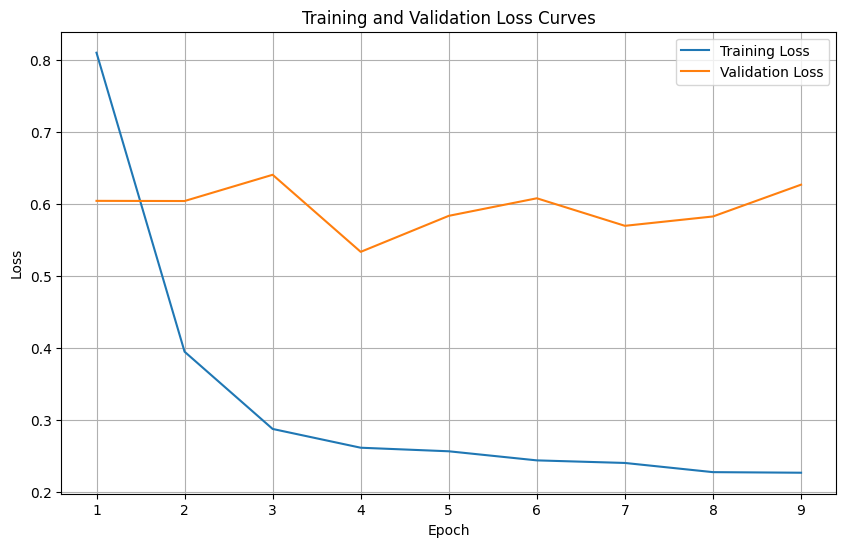

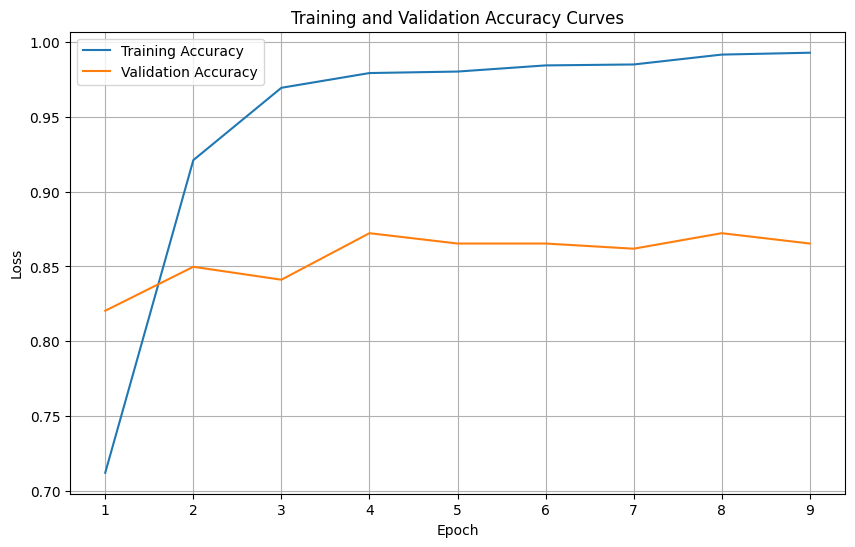


Classification Report:
               precision    recall  f1-score   support

       angry       0.90      0.86      0.88       140
       happy       0.93      0.86      0.90       148
     relaxed       0.78      0.87      0.82       146
         sad       0.86      0.86      0.86       138

    accuracy                           0.86       572
   macro avg       0.87      0.86      0.86       572
weighted avg       0.87      0.86      0.86       572


 F1 score: 0.8646084761772039; 
 Precision score: 0.8677644596367448; 
 Recall Score: 0.8635215141543313


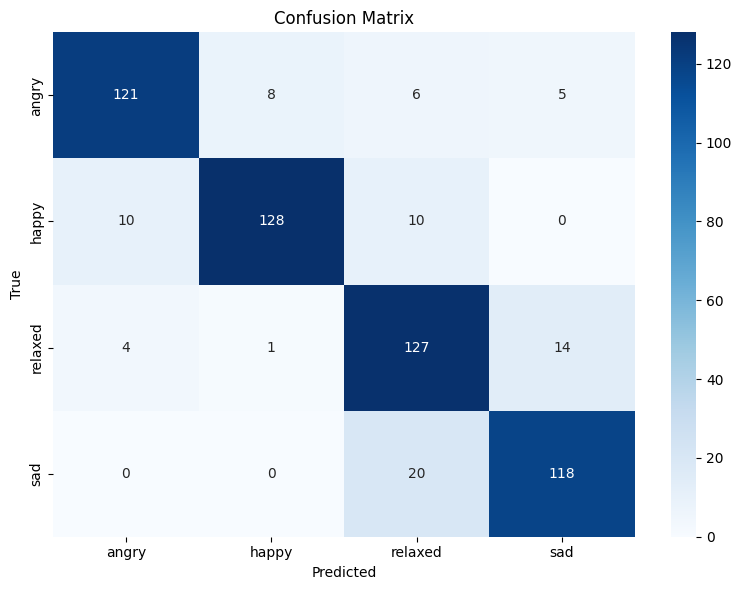

In [14]:
# load best model from training
final_model.load_state_dict(torch.load(BEST_MODEL_PATH))
final_model.to(DEVICE)
final_model.eval()

# initialise metrics
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in FULL_TEST_LOADER:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = final_model(images)
        # for test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        # for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# plotting training and validation loss curves
if 'train_losses' in globals() and 'val_losses' in globals():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    loss_curve_path = os.path.join(RESULTS_DIR, "loss_curves.png")
    plt.savefig(loss_curve_path)
    plt.show()
    logging.info("Training and Validation Loss curves saved to %s", loss_curve_path)
else:
    logging.warning("train_losses and val_losses are not defined. Skipping loss curves plot.")

# plotting training and validation acc curves
if 'train_accs' in globals() and 'val_accs' in globals():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accs)+1), train_accs, label="Training Accuracy")
    plt.plot(range(1, len(val_accs)+1), val_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Accuracy Curves")
    plt.legend()
    plt.grid(True)
    acc_curve_path = os.path.join(RESULTS_DIR, "accuracy_curves.png")
    plt.savefig(acc_curve_path)
    plt.show()
    logging.info("Training and Validation Accuracy curves saved to %s", acc_curve_path)
else:
    logging.warning("train_accs and val_accs are not defined. Skipping accuracy curves plot.")

# generate and log classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# print f1, precision, recall scores
f1 = f1_score(all_labels, all_preds, average='macro')
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
print(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")
logging.info(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")

# generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join(RESULTS_DIR, "confusion_matrix.png")
fig.savefig(conf_matrix_path)
plt.show(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)